# Example 04: PyTorch CNN

## 事前準備

In [1]:
import torch

# GPUが使えるか確認してデバイスを設定
# NOTE: `x = x.to(device) ` とすることで対象のデバイスに切り替え可能
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## CNN

In [2]:
import os
import torch
import torchinfo
from torch import nn
from torch import optim
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torch.utils.tensorboard import SummaryWriter
from torcheval.metrics import MulticlassAccuracy
from datetime import datetime
from tqdm.notebook import tqdm

import mlflow
from mlflow.tracking import MlflowClient

import matplotlib.pyplot as plt

In [3]:
# mlflowの設定
MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI")

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient()

### DataLoader設定

In [4]:
# transformを準備
affine = transforms.RandomAffine((-30, 30), scale=(0.8, 1.2))
flip = transforms.RandomHorizontalFlip(p=0.5)
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均0、標準偏差1

transform_train = transforms.Compose([
    affine,
    flip,
    transforms.ToTensor(),
    normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [5]:
# DataLoader作成
cifar10_train = CIFAR10(root="../cache/data", train=True, download=True, transform=transform_train)
cifar10_valid_test = CIFAR10(root="../cache/data", train=False, download=True, transform=transform_test)
cifar10_classes = cifar10_train.classes

In [6]:
test_size = int(len(cifar10_valid_test) * 0.5)

test_indices = list(range(0, test_size))
valid_indices = list(range(test_size, len(cifar10_valid_test)))

cifar10_test = Subset(cifar10_valid_test, test_indices)
cifar10_valid = Subset(cifar10_valid_test, valid_indices)

In [7]:
# DataLoaderの設定
BATCH_SIZE = 128

train_loader = DataLoader(cifar10_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(cifar10_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
len(cifar10_train), len(cifar10_valid), len(cifar10_test)

(50000, 5000, 5000)

### モデル構築

In [9]:
class Net(nn.Module):
    def __init__(self, n_classes: int):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)         # 入力チャネル、出力チャネル、フィルタ数
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)          # 領域のサイズ、領域の間隔
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.dropout = nn.Dropout(0.5)          # ドロップアウト率
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        入力画像: (3, 32, 32)
        conv1   : (8, 28, 28)
        pool    : (8, 14, 14)
        conv2   : (16, 10, 10)
        pool    : (16, 5, 5)
        fc1     : (256)
        fc2     : (10)
        """
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
net = Net(len(cifar10_classes))

In [11]:
torchinfo.summary(net, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 28, 28]            608
├─ReLU: 1-2                              [1, 8, 28, 28]            --
├─MaxPool2d: 1-3                         [1, 8, 14, 14]            --
├─Conv2d: 1-4                            [1, 16, 10, 10]           3,216
├─ReLU: 1-5                              [1, 16, 10, 10]           --
├─MaxPool2d: 1-6                         [1, 16, 5, 5]             --
├─Linear: 1-7                            [1, 256]                  102,656
├─ReLU: 1-8                              [1, 256]                  --
├─Dropout: 1-9                           [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 109,050
Trainable params: 109,050
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.90
Input size (MB): 0.01
Forward/b

### 学習

In [12]:
LR = 1e-4
MAX_LR = 0.01
N_EPOCHS = 50
VERBOSE = 1

HYPER_PARAM = {
    "batch_size": BATCH_SIZE,
    "lr": LR,
    "max_lr": MAX_LR,
    "n_epochs": N_EPOCHS,
    "verbose": VERBOSE,
}

EXPERIMENT_NAME = "example04_pytorch_cnn"

In [14]:
%%time
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    steps_per_epoch=len(train_loader),
    epochs=N_EPOCHS
)

record_loss_train = []
record_loss_valid = []

date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
tensorboard_log_dir = f"/example-pytorch/logs/{EXPERIMENT_NAME}/{date_str}"

writer = SummaryWriter(log_dir=tensorboard_log_dir)
print(f"tensorboard_log_dir: {tensorboard_log_dir}")

mlflow_exp = client.get_experiment_by_name(EXPERIMENT_NAME)
if mlflow_exp is None:
    mlflow_exp = client.create_experiment(EXPERIMENT_NAME)
mlflow.set_experiment(EXPERIMENT_NAME)


with mlflow.start_run(run_name=date_str):
    images, _ = next(iter(train_loader))
    images = images.to(device)
    writer.add_graph(net, images)
    mlflow.log_params(HYPER_PARAM)

    for epoch in tqdm(range(N_EPOCHS)):
        # ---------- train ----------
        net.train()
        loss_train = 0.0
        metric_acc_train = MulticlassAccuracy()
        for (x, t) in tqdm(train_loader):
            x, t = x.to(device), t.to(device)
            y = net(x)
    
            loss = loss_func(y, t)
            loss_train += loss.item()
            metric_acc_train.update(y, t)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        loss_train /= len(train_loader)
        acc_train = metric_acc_train.compute().item()
        record_loss_train.append(loss_train)
        scheduler.step()

        # ---------- validation ---------
        net.eval()
        loss_valid = 0.0
        metric_acc_valid = MulticlassAccuracy()

        with torch.no_grad():
            for (x, t) in tqdm(valid_loader):
                x, t = x.to(device), t.to(device)
                y = net(x)
        
                loss = loss_func(y, t)
                loss_valid += loss.item()
                metric_acc_valid.update(y, t)
    
        loss_valid /= len(valid_loader)
        acc_valid = metric_acc_valid.compute().item()
        record_loss_valid.append(loss_valid)
        
        writer.add_scalar("lr", scheduler.get_last_lr()[0], epoch)
        writer.add_scalar("loss/train", loss_train, epoch)
        writer.add_scalar("loss/valid", loss_valid, epoch)
        writer.add_scalar("accuracy/train", acc_train, epoch)
        writer.add_scalar("accuracy/valid", acc_valid, epoch)

        mlflow.log_metrics(
            {
                "loss_train": loss_train,
                "acc_train": acc_train,
                "loss_valid": loss_valid,
                "acc_valid": acc_valid,
            },
            step=epoch,
        )

        ckpt_dirpath = "../cache/checkpoints"
        ckpt_path = os.path.join(ckpt_dirpath, "model.pt")
        os.makedirs(ckpt_dirpath, exist_ok=True)
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
            },
            ckpt_path,
        )
        #mlflow.log_artifact(ckpt_path, artifact_path=f"checkpoints/epoch_{epoch:03d}")
        mlflow.log_artifact(ckpt_path, artifact_path=f"checkpoints/epoch_{epoch:03d}")
        
        if epoch % VERBOSE == 0:
            print(f"epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}, acc_train: {acc_train:.4f}, acc_valid: {acc_valid:.4f}")
    
    # ---------- test ----------
    net.eval()
    metric_acc_test = MulticlassAccuracy()

    with torch.no_grad():
        for (x, t) in tqdm(test_loader):
            x, t = x.to(device), t.to(device)
            y = net(x)
            metric_acc_test.update(y, t)
    
    acc_test = metric_acc_test.compute().item()
    writer.add_scalar("accuracy/test", acc_test, N_EPOCHS - 1)
    mlflow.log_metrics({"acc_test": acc_test})
    
    print(f"acc_test: {acc_test}")
    
writer.close()

tensorboard_log_dir: /example-pytorch/logs/example04_pytorch_cnn/20251014_001616


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 1, loss_train: 2.0587, loss_valid: 1.8516, acc_train: 0.2405, acc_valid: 0.3328


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 2, loss_train: 1.8220, loss_valid: 1.6790, acc_train: 0.3400, acc_valid: 0.4086


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 3, loss_train: 1.7061, loss_valid: 1.5684, acc_train: 0.3835, acc_valid: 0.4376


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 4, loss_train: 1.6408, loss_valid: 1.5430, acc_train: 0.4035, acc_valid: 0.4384


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 5, loss_train: 1.5943, loss_valid: 1.4694, acc_train: 0.4241, acc_valid: 0.4702


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 6, loss_train: 1.5733, loss_valid: 1.4491, acc_train: 0.4344, acc_valid: 0.4690


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 7, loss_train: 1.5441, loss_valid: 1.4156, acc_train: 0.4426, acc_valid: 0.4858


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 8, loss_train: 1.5185, loss_valid: 1.3796, acc_train: 0.4551, acc_valid: 0.5026


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 9, loss_train: 1.5021, loss_valid: 1.3864, acc_train: 0.4615, acc_valid: 0.4974


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 10, loss_train: 1.4818, loss_valid: 1.3472, acc_train: 0.4663, acc_valid: 0.5088


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 11, loss_train: 1.4698, loss_valid: 1.3538, acc_train: 0.4736, acc_valid: 0.5154


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 12, loss_train: 1.4574, loss_valid: 1.3181, acc_train: 0.4775, acc_valid: 0.5238


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 13, loss_train: 1.4481, loss_valid: 1.3010, acc_train: 0.4829, acc_valid: 0.5314


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 14, loss_train: 1.4292, loss_valid: 1.3069, acc_train: 0.4883, acc_valid: 0.5356


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 15, loss_train: 1.4206, loss_valid: 1.3036, acc_train: 0.4954, acc_valid: 0.5326


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 16, loss_train: 1.4138, loss_valid: 1.2839, acc_train: 0.4977, acc_valid: 0.5408


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 17, loss_train: 1.4036, loss_valid: 1.2888, acc_train: 0.5003, acc_valid: 0.5372


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 18, loss_train: 1.3958, loss_valid: 1.2568, acc_train: 0.5039, acc_valid: 0.5462


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 19, loss_train: 1.3876, loss_valid: 1.2720, acc_train: 0.5057, acc_valid: 0.5472


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 20, loss_train: 1.3822, loss_valid: 1.2720, acc_train: 0.5053, acc_valid: 0.5564


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 21, loss_train: 1.3734, loss_valid: 1.2377, acc_train: 0.5119, acc_valid: 0.5588


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 22, loss_train: 1.3586, loss_valid: 1.2606, acc_train: 0.5157, acc_valid: 0.5456


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 23, loss_train: 1.3624, loss_valid: 1.2133, acc_train: 0.5160, acc_valid: 0.5574


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 24, loss_train: 1.3529, loss_valid: 1.2342, acc_train: 0.5190, acc_valid: 0.5622


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 25, loss_train: 1.3509, loss_valid: 1.2161, acc_train: 0.5186, acc_valid: 0.5680


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 26, loss_train: 1.3442, loss_valid: 1.2169, acc_train: 0.5246, acc_valid: 0.5698


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 27, loss_train: 1.3433, loss_valid: 1.2345, acc_train: 0.5233, acc_valid: 0.5666


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 28, loss_train: 1.3383, loss_valid: 1.1927, acc_train: 0.5227, acc_valid: 0.5758


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 29, loss_train: 1.3331, loss_valid: 1.1658, acc_train: 0.5267, acc_valid: 0.5782


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 30, loss_train: 1.3295, loss_valid: 1.2163, acc_train: 0.5287, acc_valid: 0.5644


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 31, loss_train: 1.3260, loss_valid: 1.2007, acc_train: 0.5330, acc_valid: 0.5690


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 32, loss_train: 1.3261, loss_valid: 1.1708, acc_train: 0.5305, acc_valid: 0.5820


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 33, loss_train: 1.3213, loss_valid: 1.1841, acc_train: 0.5341, acc_valid: 0.5724


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 34, loss_train: 1.3167, loss_valid: 1.1744, acc_train: 0.5350, acc_valid: 0.5806


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 35, loss_train: 1.3133, loss_valid: 1.1617, acc_train: 0.5332, acc_valid: 0.5904


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 36, loss_train: 1.3074, loss_valid: 1.1639, acc_train: 0.5381, acc_valid: 0.5790


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 37, loss_train: 1.3058, loss_valid: 1.1540, acc_train: 0.5353, acc_valid: 0.5896


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 38, loss_train: 1.3010, loss_valid: 1.1636, acc_train: 0.5364, acc_valid: 0.5850


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 39, loss_train: 1.2951, loss_valid: 1.1442, acc_train: 0.5423, acc_valid: 0.5874


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 40, loss_train: 1.2973, loss_valid: 1.1517, acc_train: 0.5399, acc_valid: 0.5892


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 41, loss_train: 1.2931, loss_valid: 1.1572, acc_train: 0.5408, acc_valid: 0.5952


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 42, loss_train: 1.2904, loss_valid: 1.1558, acc_train: 0.5440, acc_valid: 0.5936


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 43, loss_train: 1.2930, loss_valid: 1.1350, acc_train: 0.5414, acc_valid: 0.5950


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 44, loss_train: 1.2824, loss_valid: 1.1497, acc_train: 0.5448, acc_valid: 0.5906


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 45, loss_train: 1.2784, loss_valid: 1.1210, acc_train: 0.5483, acc_valid: 0.5998


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 46, loss_train: 1.2813, loss_valid: 1.1092, acc_train: 0.5466, acc_valid: 0.6008


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 47, loss_train: 1.2771, loss_valid: 1.1413, acc_train: 0.5488, acc_valid: 0.6026


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 48, loss_train: 1.2721, loss_valid: 1.1206, acc_train: 0.5501, acc_valid: 0.6010


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 49, loss_train: 1.2726, loss_valid: 1.1251, acc_train: 0.5528, acc_valid: 0.6020


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 50, loss_train: 1.2723, loss_valid: 1.1104, acc_train: 0.5512, acc_valid: 0.5962


  0%|          | 0/40 [00:00<?, ?it/s]

acc_test: 0.6129999756813049
🏃 View run 20251014_001616 at: http://mlflow:5000/#/experiments/2/runs/db1a197bf2fa4c4a8bdfc0b874f981c9
🧪 View experiment at: http://mlflow:5000/#/experiments/2
CPU times: user 6min 13s, sys: 8.6 s, total: 6min 22s
Wall time: 6min 24s


### 誤差の推移

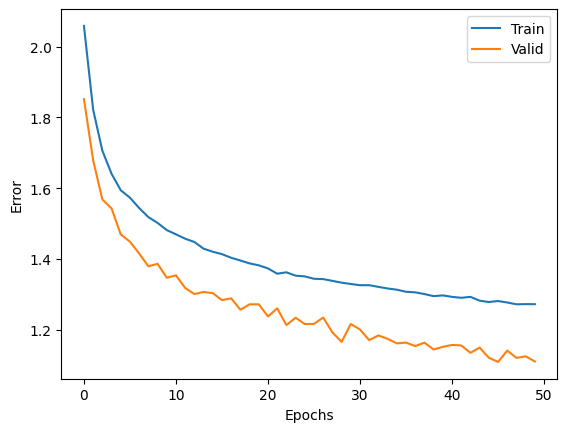

In [15]:
plt.plot(range(len(record_loss_train)), record_loss_train, label='Train')
plt.plot(range(len(record_loss_valid)), record_loss_valid, label='Valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### 訓練済みモデルを使用した予測

In [16]:
from torch.utils import data

def get_sample_image(dataset: data.Dataset) -> tuple[torch.Tensor, torch.Tensor]:
    cifar10_test = CIFAR10(root='../cache/data', train=False, download=True, transform=transform_test)
    cifar10_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    images, labels = next(iter(cifar10_loader))

    select_index = 0
    return images[select_index], labels[select_index]

def show_image(image: torch.Tensor) -> None:
    plt.imshow(image.permute(1, 2, 0))
    # ラベルとメモリを非表示に設定
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.show()

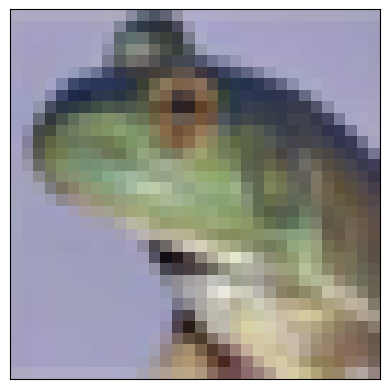

answer: frog, predict: frog


In [17]:
image, label = get_sample_image(cifar10_test)
show_image(image)

net.eval()
image, label = image.to(device), label.to(device)
y = net(image)

print(f"answer: {cifar10_classes[label]}, predict: {cifar10_classes[y.argmax().item()]}")